In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error
import xgboost as xgb


In [2]:
!pip install xgboost


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\galch\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv')

# Fill missing values
df = df.fillna(0)

# Target and features
y = df.fuel_efficiency_mpg
X = df.drop('fuel_efficiency_mpg', axis=1)

# Split into train/val/test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=1)  # 0.25 * 0.8 = 0.2

# DictVectorizer
dv = DictVectorizer(sparse=True)
X_train_dict = X_train.to_dict(orient='records')
X_val_dict = X_val.to_dict(orient='records')

X_train_dv = dv.fit_transform(X_train_dict)
X_val_dv = dv.transform(X_val_dict)


In [8]:
X_train.columns

Index(['engine_displacement', 'num_cylinders', 'horsepower', 'vehicle_weight',
       'acceleration', 'model_year', 'origin', 'fuel_type', 'drivetrain',
       'num_doors'],
      dtype='object')

In [6]:
df.isnull().sum()

engine_displacement    0
num_cylinders          0
horsepower             0
vehicle_weight         0
acceleration           0
model_year             0
origin                 0
fuel_type              0
drivetrain             0
num_doors              0
fuel_efficiency_mpg    0
dtype: int64

# Q1 — Decision Tree with max_depth=1

In [9]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train_dv, y_train)

feature_names = dv.get_feature_names_out()
split_feature = feature_names[dt.tree_.feature[0]]
split_feature


'vehicle_weight'

In [10]:
from sklearn.tree import export_text
r = export_text(dt, feature_names=list(feature_names))
print(r)

|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



# Q2 — Random Forest with n_estimators=10

In [12]:
from sklearn.metrics import root_mean_squared_error
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train_dv, y_train)
y_pred = rf.predict(X_val_dv)

rmse = root_mean_squared_error(y_val, y_pred)
rmse


0.4595777223092726

# Question 3

In [14]:
n_estimators = np.arange(10, 201, 10)
rmse_list = []
for n in n_estimators:
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train_dv, y_train)
    y_pred = rf.predict(X_val_dv)
    rmse = round(root_mean_squared_error(y_val, y_pred), 3)
    rmse_list.append(rmse)
    print(f'n_estimators: {n}, RMSE: {rmse}')

n_estimators: 10, RMSE: 0.46
n_estimators: 20, RMSE: 0.454
n_estimators: 30, RMSE: 0.452
n_estimators: 40, RMSE: 0.449
n_estimators: 50, RMSE: 0.447
n_estimators: 60, RMSE: 0.445
n_estimators: 70, RMSE: 0.445
n_estimators: 80, RMSE: 0.445
n_estimators: 90, RMSE: 0.445
n_estimators: 100, RMSE: 0.445
n_estimators: 110, RMSE: 0.444
n_estimators: 120, RMSE: 0.444
n_estimators: 130, RMSE: 0.444
n_estimators: 140, RMSE: 0.443
n_estimators: 150, RMSE: 0.443
n_estimators: 160, RMSE: 0.443
n_estimators: 170, RMSE: 0.443
n_estimators: 180, RMSE: 0.442
n_estimators: 190, RMSE: 0.442
n_estimators: 200, RMSE: 0.442


# Question 4

In [18]:
max_depths = [10, 15, 20, 25]
n_estimators = np.arange(10, 201, 10)
mean_rmse = 0
best_rmse = float('inf')
best_params = None
for max_depth in max_depths:
    for n in n_estimators:
        rf = RandomForestRegressor(n_estimators=n, max_depth=max_depth, random_state=1, n_jobs=-1)
        rf.fit(X_train_dv, y_train)
        y_pred = rf.predict(X_val_dv)
        rmse = round(root_mean_squared_error(y_val, y_pred), 3)
        mean_rmse += rmse
        #print(f'max_depth: {max_depth}, n_estimators: {n}, RMSE: {rmse}')
    mean_rmse /= len(n_estimators)
    if mean_rmse < best_rmse:
        best_rmse = mean_rmse
        best_params = (max_depth, n)
    #print(f'Average RMSE for max_depth {max_depth}: {mean_rmse}')
    mean_rmse = 0
print(f'Best params: max_depth={best_params[0]}, n_estimators={best_params[1]} with RMSE={best_rmse}')

Best params: max_depth=10, n_estimators=200 with RMSE=0.4418500000000001


In [21]:
depths = [10, 15, 20, 25]
results = {}

for d in depths:
    rmses = []
    for n in range(10, 210, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1)
        rf.fit(X_train_dv, y_train)
        y_pred = rf.predict(X_val_dv)
        rmse = root_mean_squared_error(y_val, y_pred)
        rmses.append(rmse)
    results[d] = np.mean(rmses)

results


{10: np.float64(0.4418078609323356),
 15: np.float64(0.4454166445638107),
 20: np.float64(0.44625292424422536),
 25: np.float64(0.4459099362616163)}

# Question 5

In [32]:
rf = RandomForestRegressor(
    n_estimators=10,
    max_depth=20,
    random_state=1,
    n_jobs=-1
)
rf.fit(X_train_dv, y_train)

importances = rf.feature_importances_
feature_importances = sorted(zip(importances, dv.get_feature_names_out()), reverse=True)
feature_importances[:10]


[(np.float64(0.9591499647407432), 'vehicle_weight'),
 (np.float64(0.015997897714266227), 'horsepower'),
 (np.float64(0.011479700631429378), 'acceleration'),
 (np.float64(0.0032727919136094925), 'engine_displacement'),
 (np.float64(0.0032123000947946764), 'model_year'),
 (np.float64(0.0023433469524512048), 'num_cylinders'),
 (np.float64(0.0016349895439307014), 'num_doors'),
 (np.float64(0.0005397216891829147), 'origin=USA'),
 (np.float64(0.0005187396385869679), 'origin=Europe'),
 (np.float64(0.00046224649550974243), 'origin=Asia')]

In [35]:
!pip install matplotlib


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\galch\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ------- -------------------------------- 1.6/8.1 MB 9.4 MB/s eta 0:00:01
   -------------------- ------------------- 4.2/8.1 MB 11.5 MB/s eta 0:00:01
   ---------------------------- ----------- 5.8/8.1 MB 11.0 MB/s eta 0:00:01
   ---------------------------------- ----- 7.1/8.1 MB 9.7 MB/s eta 0:00:01
   -------------------------------------- - 7.9/8.1 MB 8.7 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 7.7 MB/s  0:00:01
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ------------- -------------------------- 0.8/2.3 MB 4.8 MB/s eta 0:00:01
   --------------------------- ------------ 1.6/2.3 MB 4.7 MB/s eta 0:00:01
   ---------------------------------------- 2.3/2.3 MB 4.2 MB/s  0:00:00

   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]


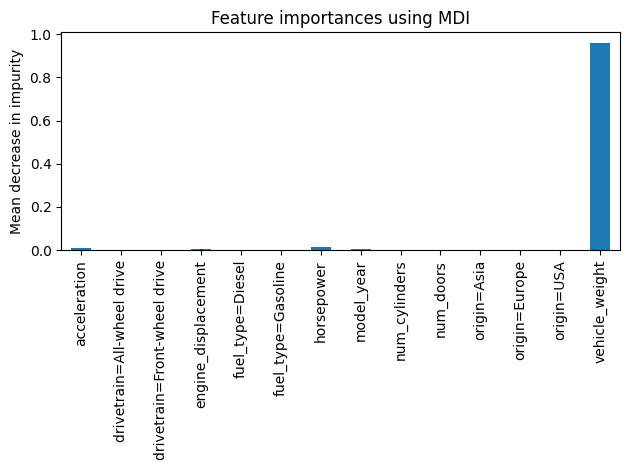

In [36]:

import numpy as np
import matplotlib.pyplot as plt

std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

import pandas as pd

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# Q6

In [23]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [25]:
features = list(dv.get_feature_names_out())

In [28]:
dtrain = xgb.DMatrix(X_train_dv, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val_dv, label=y_val, feature_names=features)

In [29]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [30]:
best_rmse = float('inf')
for eta in [0.3, 0.1]:
    print(f"\n--- eta={eta} ---")
    xgb_params = {
        'eta': eta,
        'max_depth': 6,
        'min_child_weight': 1,
        'objective': 'reg:squarederror',
        'nthread': 8,
        'seed': 1,
        'verbosity': 0,
    }

    model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist, verbose_eval=False)
    y_pred = model.predict(dval)
    rmse = root_mean_squared_error(y_val, y_pred)
    if rmse < best_rmse:
        best_rmse = rmse
    print('RMSE:', rmse)
print(f'Best RMSE: {best_rmse}')


--- eta=0.3 ---
RMSE: 0.45017755678087246

--- eta=0.1 ---
RMSE: 0.42622800553359225
Best RMSE: 0.42622800553359225
